# Linear Regression (Project 6)

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np

In [30]:
data = pd.read_csv("RRCA_baseflow.csv")
data

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
0,710732,144,1086190,14476800,0.59,18.99,0.0,0.145161
1,710763,144,1086190,14476800,0.97,29.63,0.0,0.445161
2,710791,144,1086190,14476800,1.34,29.63,0.0,1.332203
3,710822,144,1086190,14476800,1.79,29.63,0.0,2.932203
4,710852,144,1086190,14476800,8.23,29.63,0.0,3.728689
...,...,...,...,...,...,...,...,...
15586,721810,98,721870,14387040,0.00,0.00,0.0,0.298500
15587,721841,98,721870,14387040,0.00,0.00,0.0,0.211475
15588,721871,98,721870,14387040,0.00,0.00,0.0,0.122951
15589,721902,98,721870,14387040,0.00,0.00,0.0,0.120000


#### Removing rows if they have NaN values

In [31]:
data = data.dropna()
data

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
0,710732,144,1086190,14476800,0.59,18.99,0.0,0.145161
1,710763,144,1086190,14476800,0.97,29.63,0.0,0.445161
2,710791,144,1086190,14476800,1.34,29.63,0.0,1.332203
3,710822,144,1086190,14476800,1.79,29.63,0.0,2.932203
4,710852,144,1086190,14476800,8.23,29.63,0.0,3.728689
...,...,...,...,...,...,...,...,...
15586,721810,98,721870,14387040,0.00,0.00,0.0,0.298500
15587,721841,98,721870,14387040,0.00,0.00,0.0,0.211475
15588,721871,98,721870,14387040,0.00,0.00,0.0,0.122951
15589,721902,98,721870,14387040,0.00,0.00,0.0,0.120000


#### It does not look to have any NaN values

### Adding new date features like year, months, and seasons

In [32]:
##### Subtracting 693963 from Data column
data["Date"] = data["Date"] - 693963
data['Date'] = pd.to_datetime(data.Date, unit='D', origin=pd.Timestamp('1900-01-01'))

data['year'] = data.Date.dt.year
data['month'] = data.Date.dt.month
data['day'] = data.Date.dt.day

display(data)

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,year,month,day
0,1945-11-30,144,1086190,14476800,0.59,18.99,0.0,0.145161,1945,11,30
1,1945-12-31,144,1086190,14476800,0.97,29.63,0.0,0.445161,1945,12,31
2,1946-01-28,144,1086190,14476800,1.34,29.63,0.0,1.332203,1946,1,28
3,1946-02-28,144,1086190,14476800,1.79,29.63,0.0,2.932203,1946,2,28
4,1946-03-30,144,1086190,14476800,8.23,29.63,0.0,3.728689,1946,3,30
...,...,...,...,...,...,...,...,...,...,...,...
15586,1976-03-30,98,721870,14387040,0.00,0.00,0.0,0.298500,1976,3,30
15587,1976-04-30,98,721870,14387040,0.00,0.00,0.0,0.211475,1976,4,30
15588,1976-05-30,98,721870,14387040,0.00,0.00,0.0,0.122951,1976,5,30
15589,1976-06-30,98,721870,14387040,0.00,0.00,0.0,0.120000,1976,6,30


### We will use day and month for Defining seasons

### Defining seasons as well

In [33]:
def get_season(month, day):
    if (month == 3 and day >= 20) or (month == 4) or (month == 5) or (month == 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month == 7) or (month == 8) or (month == 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month == 10) or (month == 11) or (month == 12 and day < 21):
        return 'Fall'
    else:
        return 'Winter'

data['season'] = data.apply(lambda row: get_season(row['month'], row['day']), axis=1)

data

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,year,month,day,season
0,1945-11-30,144,1086190,14476800,0.59,18.99,0.0,0.145161,1945,11,30,Fall
1,1945-12-31,144,1086190,14476800,0.97,29.63,0.0,0.445161,1945,12,31,Winter
2,1946-01-28,144,1086190,14476800,1.34,29.63,0.0,1.332203,1946,1,28,Winter
3,1946-02-28,144,1086190,14476800,1.79,29.63,0.0,2.932203,1946,2,28,Winter
4,1946-03-30,144,1086190,14476800,8.23,29.63,0.0,3.728689,1946,3,30,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...
15586,1976-03-30,98,721870,14387040,0.00,0.00,0.0,0.298500,1976,3,30,Spring
15587,1976-04-30,98,721870,14387040,0.00,0.00,0.0,0.211475,1976,4,30,Spring
15588,1976-05-30,98,721870,14387040,0.00,0.00,0.0,0.122951,1976,5,30,Spring
15589,1976-06-30,98,721870,14387040,0.00,0.00,0.0,0.120000,1976,6,30,Summer


## Applying One-Hot-Encoding for using in making the model


##### Also, to make the model simpler we just use `season`. Therefore, we remove `year, month, day, and Date` columns

#### We removed month and day because we used them in creating the new column named `season`

#### This part is for creating our model!

In [34]:
encoder = OneHotEncoder()

OneHot = encoder.fit_transform(data[["Segment_id", "season"]])
one_hot_feature_names = encoder.get_feature_names_out(['Segment_id', "season"])
one_hot_df = pd.DataFrame(OneHot.toarray(), columns=one_hot_feature_names)
data_encoded = pd.concat([data, one_hot_df], axis=1)
data_for_models = data_encoded.drop(columns=["Segment_id", "Date", "year", "day", "season", "month"])
data_for_models

,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,Segment_id_40,Segment_id_51,Segment_id_53,Segment_id_55,...,Segment_id_189,Segment_id_194,Segment_id_196,Segment_id_205,Segment_id_239,Segment_id_256,season_Fall,season_Spring,season_Summer,season_Winter
0,1086190,14476800,0.59,18.99,0.0,0.145161,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1086190,14476800,0.97,29.63,0.0,0.445161,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1086190,14476800,1.34,29.63,0.0,1.332203,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1086190,14476800,1.79,29.63,0.0,2.932203,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1086190,14476800,8.23,29.63,0.0,3.728689,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15586,721870,14387040,0.00,0.00,0.0,0.298500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15587,721870,14387040,0.00,0.00,0.0,0.211475,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15588,721870,14387040,0.00,0.00,0.0,0.122951,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15589,721870,14387040,0.00,0.00,0.0,0.120000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Mean Baseflow over seasons

Text(0.5, 1.0, 'Baseflow in different seasons')

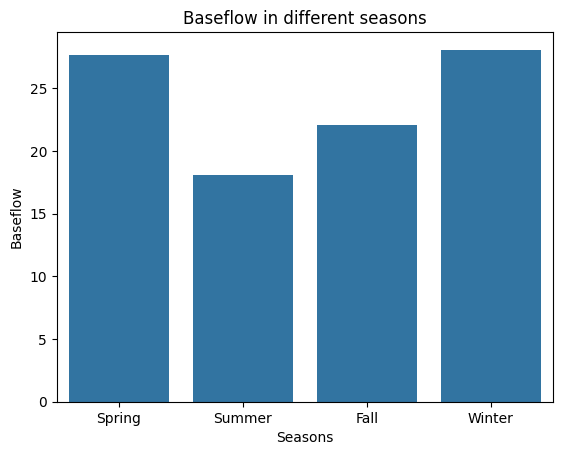

In [35]:
barData = data.groupby(["season"]).agg({"Observed": "mean"}).reset_index()
sns.barplot(data=barData, x="season", y="Observed", order=["Spring", "Summer", "Fall", "Winter"])
plt.xlabel("Seasons")
plt.ylabel("Baseflow")
plt.title("Baseflow in different seasons")

##### Looks summer in average was the most dry one

### Precipitation vs Irrigation pumping

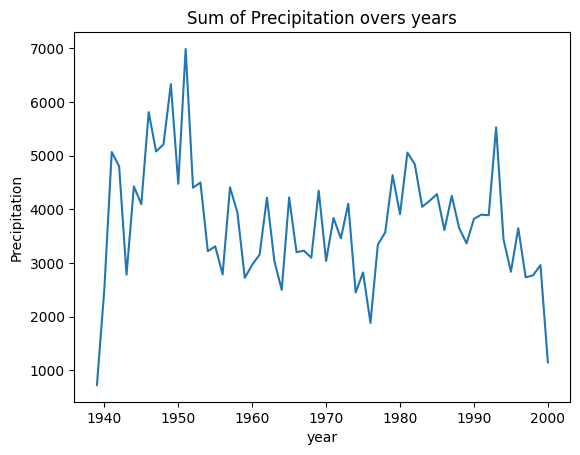

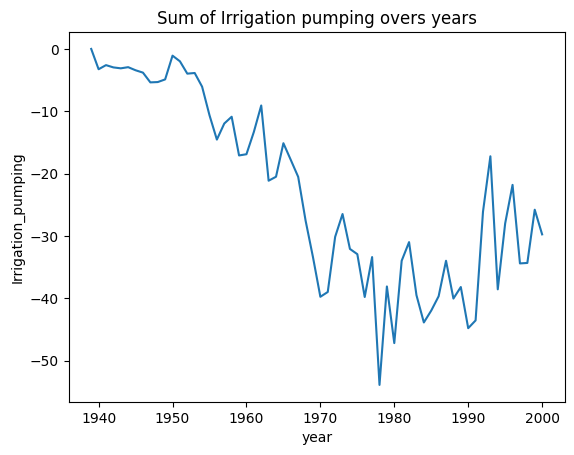

In [36]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 3))
precipitationData = data.groupby(["year"]).agg({"Precipitation": "sum", "Irrigation_pumping": "sum"}).reset_index()
sns.lineplot(y="Precipitation", x="year", data=precipitationData)
plt.title("Sum of Precipitation overs years")
plt.show()
sns.lineplot(y="Irrigation_pumping", x="year", data=precipitationData)
plt.title("Sum of Irrigation pumping overs years")
plt.show()


#### Looks Irrigation increased when Precipitation decreased over years

### Location of Baseflow observed

c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,year,month,day,season
45,1944-04-30,256,1941550,14524320,4.60,35.50,0.0,747.80328,1944,4,30,Spring
41,1949-04-30,239,1630030,14550720,2.32,26.24,0.0,712.55738,1949,4,30,Spring


c:\Users\Sadra\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


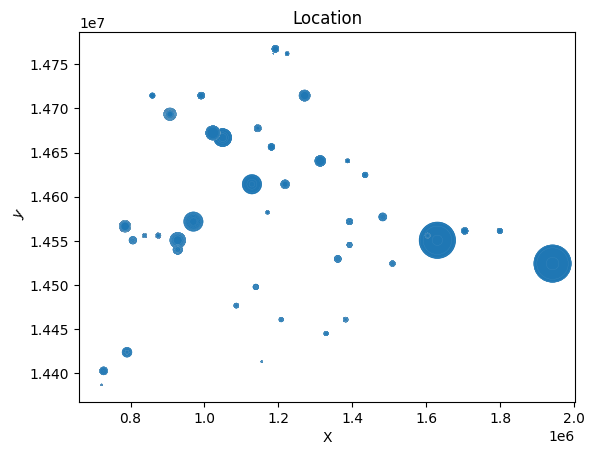

In [75]:
sns.scatterplot(x="x", y="y", data=data, s=data["Observed"])
plt.xlabel("X")
plt.ylabel("y", rotation=60)
plt.title("Location") 
top_observed = data.groupby(['x', 'y']).apply(lambda x: x.nlargest(1, 'Observed')).reset_index(drop=True)

# Sort by 'Observed' in descending order to get the top 2 different (x, y) coordinates with the highest values in 'Observed'
top_2_observed = top_observed.nlargest(2, 'Observed')
display(top_2_observed)


### The top 2 locations were observed with their data info

## Finding the unique values of the segments

In [38]:
segments = data["Segment_id"].unique()
segments

array([144, 154, 176, 171, 152,  55, 118,  65,  64,  63,  40, 135,  53,
       123, 157, 147, 170, 136, 149,  60, 188, 194, 239, 256, 205,  59,
       148, 138,  62,  96, 178, 186, 159, 130,  97,  51, 145, 196, 146,
       189,  56,  98], dtype=int64)

#### Baseflow in different segment_id over years

Text(0.5, 1.0, 'Observed Baseflow over years')

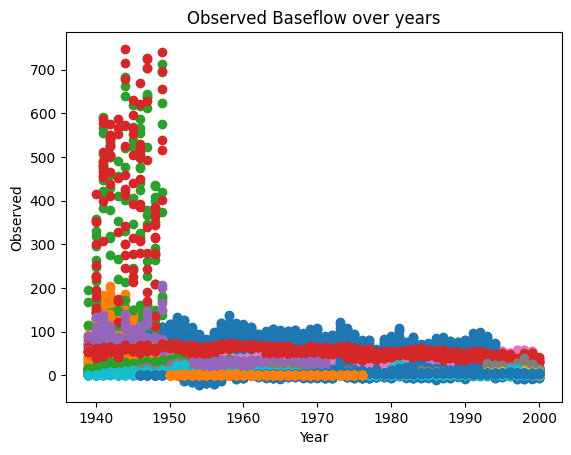

In [39]:
for seg in segments:
    plt.scatter(x=data[data.Segment_id == seg].year, y=data[data.Segment_id == seg].Observed)
# data.plot(kind="scatter", x="year", y="Observed")
plt.xlabel("Year")
plt.ylabel("Observed")
plt.title("Observed Baseflow over years")

Text(0.5, 1.0, 'Evapotranspiration vs Observed baseflow')

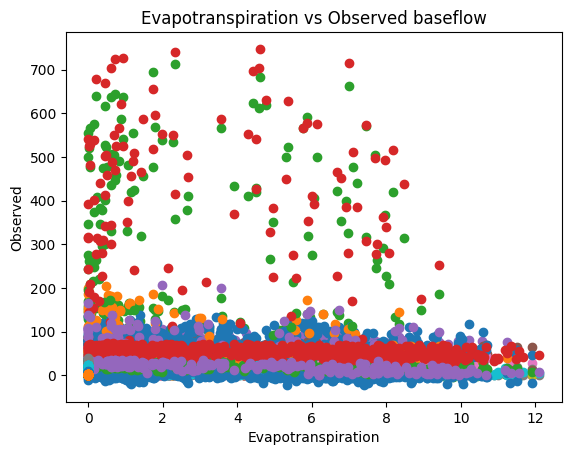

In [40]:
for seg in segments:
    plt.scatter(x=data[data.Segment_id == seg].Evapotranspiration, y=data[data.Segment_id == seg].Observed)
plt.xlabel("Evapotranspiration")
plt.ylabel("Observed")
plt.title("Evapotranspiration vs Observed baseflow")    

##### It does not give us a good view so we have to test it in different segments

Text(0.5, 1.0, 'Precipitation vs Observed baseflow')

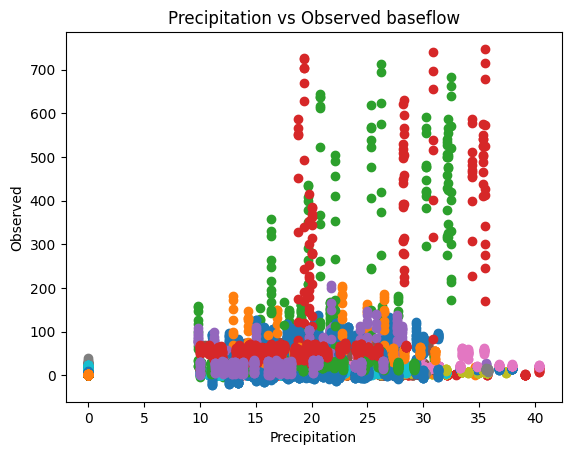

In [41]:
for seg in segments:
    plt.scatter(x=data[data.Segment_id == seg].Precipitation, y=data[data.Segment_id == seg].Observed)
plt.xlabel("Precipitation")
plt.ylabel("Observed")
plt.title("Precipitation vs Observed baseflow")

#### We need to test this one in different segments as well because it does not give us valuable information

Text(0.5, 1.0, 'Irrigation_pumping vs baseflow')

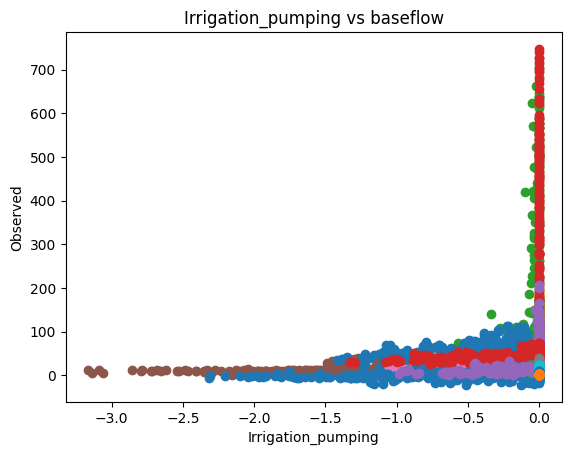

In [42]:
for seg in segments:
    plt.scatter(x=data[data.Segment_id == seg].Irrigation_pumping, y=data[data.Segment_id == seg].Observed)
plt.xlabel("Irrigation_pumping")
plt.ylabel("Observed")
plt.title("Irrigation_pumping vs baseflow")

#### It looks that by increasing irrigation pumping the baseflow decreses but to make sure we will test it in different segments

## Irrigation pumping over time

Text(0.5, 1.0, 'Irrigation_pumping over years')

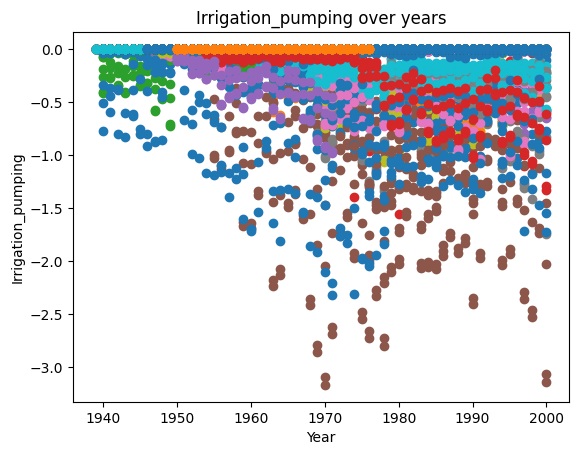

In [43]:
for seg in segments:
    plt.scatter(x=data[data.Segment_id == seg].year, y=data[data.Segment_id == seg].Irrigation_pumping)
plt.xlabel("Year")
plt.ylabel("Irrigation_pumping")
plt.title("Irrigation_pumping over years")

#### Looks pumping increased over the time

#### Seed defined to have the same result from selection in every runs

In [44]:
random_seed = 5
random.seed(random_seed)

### Randomly selected segments to check out the correlations instead of checking all the segments

In [45]:
random_segments = random.sample(list(segments), 12)

#### Check if there is any correlation between randomly selected segments in Evapotranspiration vs observed baseflow

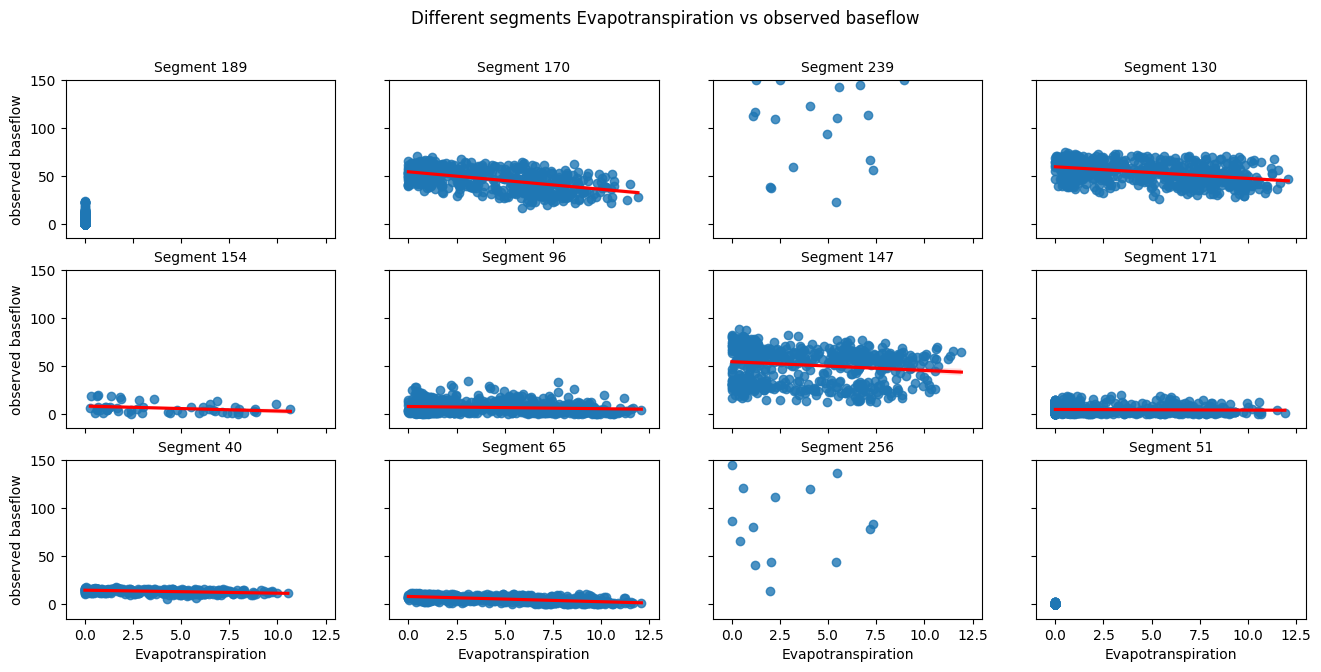

In [46]:
fig, axs = plt.subplots(3, 4, figsize=(16, 7))
j = 0
k = 0
for seg in (random_segments):
  sns.regplot(x=data[data.Segment_id == seg].Evapotranspiration, y=data[data.Segment_id == seg].Observed, ax=axs[j, k], line_kws={"color": "red"})
  # axs[j, k].scatter(x=data[data.Segment_id == seg].Evapotranspiration, y=data[data.Segment_id == seg].Observed)
  axs[j, k].set_title(f"Segment {seg}", fontsize=10)
  axs[j, k].set_xlim(-1, 13)
  axs[j, k].set_ylim(-15, 150)
  k += 1
  if k == 4:
    j += 1
    k = 0
        
for ax in axs.flat:
  ax.set(xlabel="Evapotranspiration", ylabel="observed baseflow")

for ax in fig.get_axes():
  ax.label_outer()
fig.suptitle("Different segments Evapotranspiration vs observed baseflow")
plt.show()

##### Sounds by increasing Evapotranspiration the baseflow decreases

#### Check if there is any correlation between randomly selected segments in Irrigation_pumping vs observed baseflow

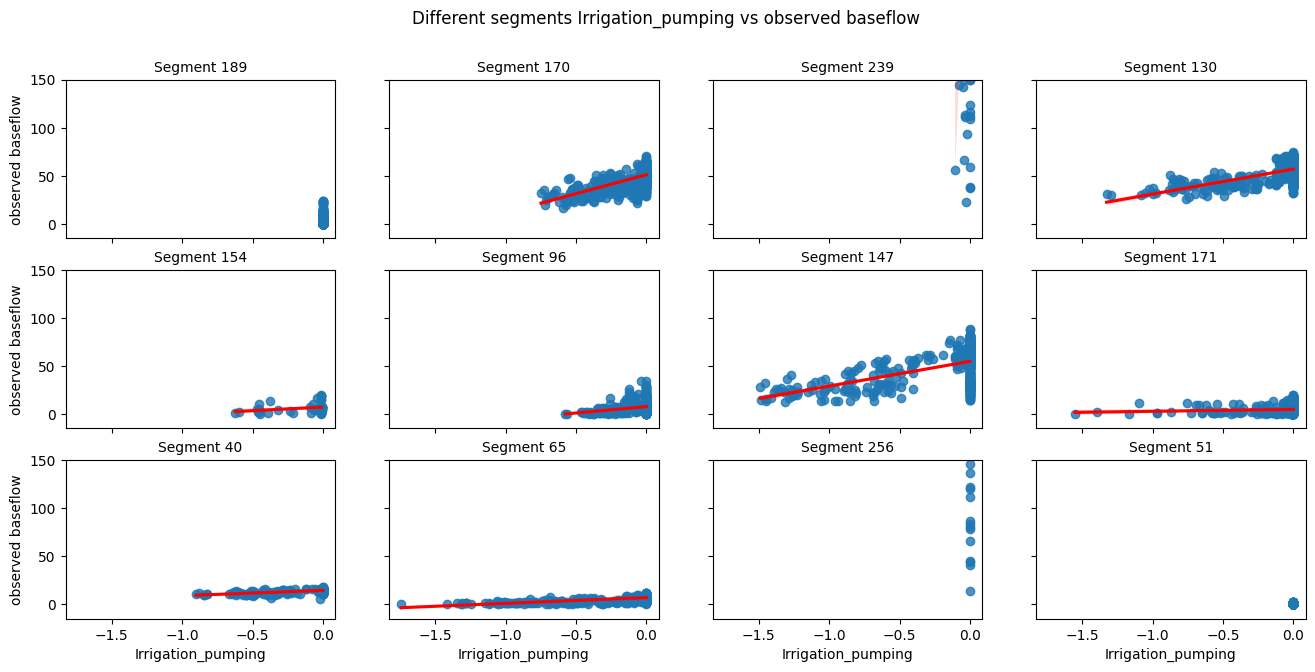

In [47]:
fig, axs = plt.subplots(3, 4, figsize=(16, 7), sharex=True, sharey=True)
j = 0
k = 0
for seg in (random_segments):
  sns.regplot(x=data[data.Segment_id == seg].Irrigation_pumping, y=data[data.Segment_id == seg].Observed, ax=axs[j, k], line_kws={"color": "red"})
    # axs[j, k].scatter(x=data[data.Segment_id == seg].Irrigation_pumping, y=data[data.Segment_id == seg].Observed)
  axs[j, k].set_title(f"Segment {seg}", fontsize=10)
    # axs[j, k].set_xlim(-5, 1)
  axs[j, k].set_ylim(-15, 150)
  k += 1
  if k == 4:
      j += 1
      k = 0
        
for ax in axs.flat:
  ax.set(xlabel="Irrigation_pumping", ylabel="observed baseflow")

for ax in fig.get_axes():
  ax.label_outer()
fig.suptitle("Different segments Irrigation_pumping vs observed baseflow")
plt.show()

#### Sounds by increasing (negative value means pumping out here means increasing pumping) irrigation pumping the basefolw decreases

#### Check if there is any correlation between randomly selected segments in Precipitation vs observed baseflow

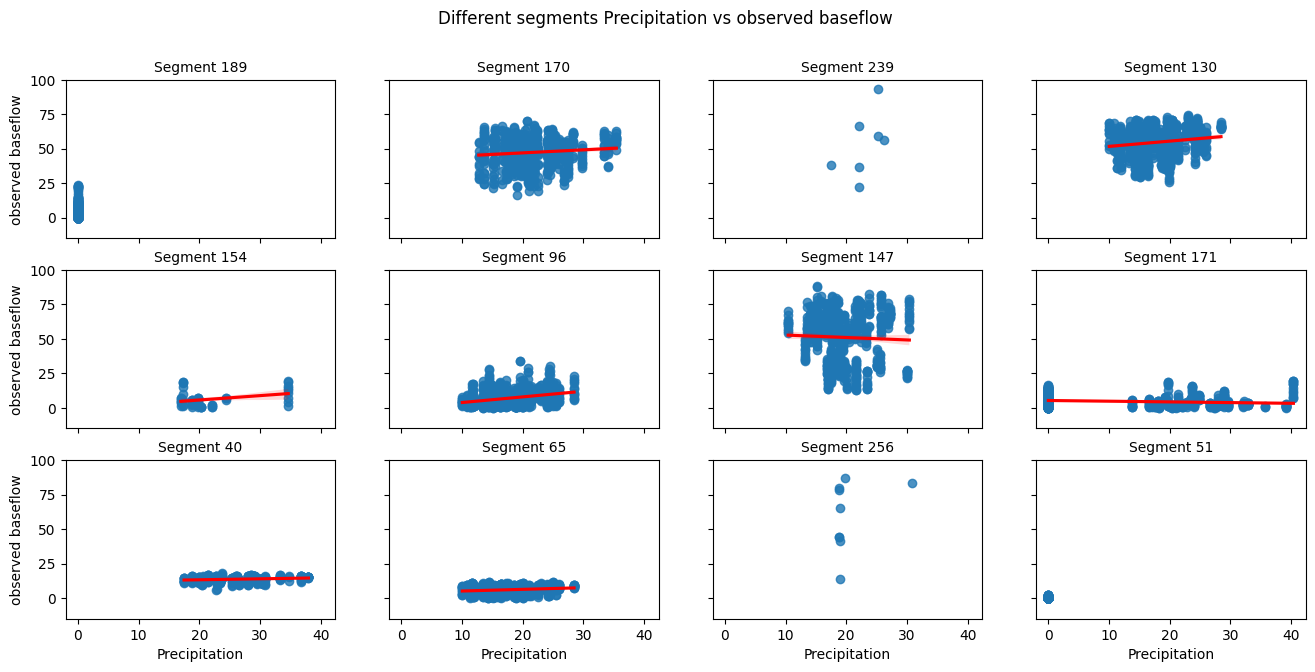

In [48]:
fig, axs = plt.subplots(3, 4, figsize=(16, 7), sharex=True, sharey=True)
j = 0
k = 0
for seg in (random_segments):
  sns.regplot(x=data[data.Segment_id == seg].Precipitation, y=data[data.Segment_id == seg].Observed, ax=axs[j, k], line_kws={"color": "red"})
  # axs[j, k].scatter(x=data[data.Segment_id == seg].Precipitation, y=data[data.Segment_id == seg].Observed)
  axs[j, k].set_title(f"Segment {seg}", fontsize=10)
  axs[j, k].set_ylim(-15, 100)
  k += 1
  if k == 4:
      j += 1
      k = 0
        
for ax in axs.flat:
  ax.set(xlabel="Precipitation", ylabel="observed baseflow")

for ax in fig.get_axes():
  ax.label_outer()
fig.suptitle("Different segments Precipitation vs observed baseflow")
plt.show()

#### It doesn't look to have any correlation between Precipitation and baseflow of these 12 segments

In [49]:
data_for_models

,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,Segment_id_40,Segment_id_51,Segment_id_53,Segment_id_55,...,Segment_id_189,Segment_id_194,Segment_id_196,Segment_id_205,Segment_id_239,Segment_id_256,season_Fall,season_Spring,season_Summer,season_Winter
0,1086190,14476800,0.59,18.99,0.0,0.145161,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1086190,14476800,0.97,29.63,0.0,0.445161,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1086190,14476800,1.34,29.63,0.0,1.332203,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1086190,14476800,1.79,29.63,0.0,2.932203,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1086190,14476800,8.23,29.63,0.0,3.728689,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15586,721870,14387040,0.00,0.00,0.0,0.298500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15587,721870,14387040,0.00,0.00,0.0,0.211475,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15588,721870,14387040,0.00,0.00,0.0,0.122951,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15589,721870,14387040,0.00,0.00,0.0,0.120000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Creating Linear Regression model and applying 10-fold cross-validation with all features

In [50]:
model = LinearRegression()

kf = KFold(n_splits=10, shuffle=True, random_state=42)

X = data_for_models.drop(columns=["Observed"])
y = data_for_models["Observed"]

intercepts = []
coefficients = []
mse_scores = []
r_squared = []
i = 1
print("--------------------------")
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    
    intercepts.append(model.intercept_)
    coefficients.append(model.coef_)
    r_squared.append(r2_score(y_test, y_pred))
    print(f"R-Squared in fold {i}: {r2_score(y_test, y_pred)}")
    i += 1


print("--------------------------")
intercepts = np.array(intercepts)
coefficients = np.array(coefficients)


print("Mean CV R-Squared:", np.mean(r_squared))
print("Mean CV MSE:", np.mean(mse_scores))


print("Mean Intercept:", np.mean(intercepts))
print("------------------------------------")
print("This is the mean of the coefficient of all the features")
print("Mean Coefficients:", np.mean(coefficients, axis=0))

--------------------------
R-Squared in fold 1: 0.8212602993465563
R-Squared in fold 2: 0.8093331737146002
R-Squared in fold 3: 0.838812266727394
R-Squared in fold 4: 0.6327883843720868
R-Squared in fold 5: 0.8249104365954864
R-Squared in fold 6: 0.7804190507849733
R-Squared in fold 7: 0.8640492418183554
R-Squared in fold 8: 0.7855579571855964
R-Squared in fold 9: 0.8638922147428988
R-Squared in fold 10: 0.8397662334835396
--------------------------
Mean CV R-Squared: 0.8060789258771488
Mean CV MSE: 591.7876827723433
Mean Intercept: 10626.618411731295
------------------------------------
This is the mean of the coefficient of all the features
Mean Coefficients: [ 3.21309464e-04 -7.53263005e-04 -1.05863482e+00  5.74174131e-01
  1.79091252e+00 -2.34232385e+02 -1.40427405e+02  1.65649828e+02
  1.51234697e+01 -1.50136795e+01  6.28040607e+01  7.06067892e+01
 -1.76122107e+02 -1.86720799e+02 -1.88170808e+02  6.88360201e+01
  7.59761924e+01  4.71628278e+00 -2.05321134e+01  1.05785349e+02
  1.8

### Using all the features for making the model (did not use Cross-Validation)

In [51]:
init = 'Observed ~ '
columns = data_for_models.columns
for i in range(len(data_for_models.columns)):
    if data_for_models.columns[i] != "Observed":
        init += data_for_models.columns[i]
        if i != len(data_for_models.columns) - 1:
            init += " + "
lm = smf.ols(formula=init, data=data_for_models).fit()
display(f"R-squared: {lm.rsquared}")
display(lm.params)
display(lm.summary())

'R-squared: 0.8164925478311236'

Intercept             8345.216352
x                        0.000321
y                       -0.000754
Evapotranspiration      -1.058868
Precipitation            0.574246
Irrigation_pumping       1.788793
Segment_id_40          -35.611836
Segment_id_51           58.232334
Segment_id_53          364.404940
Segment_id_55          213.838330
Segment_id_56          183.687889
Segment_id_59          261.534214
Segment_id_60          269.334481
Segment_id_62           22.521556
Segment_id_63           11.922004
Segment_id_64           10.468939
Segment_id_65          267.569887
Segment_id_96          274.712200
Segment_id_97          203.422908
Segment_id_98          178.173882
Segment_id_118         304.528351
Segment_id_123         387.723906
Segment_id_130         341.088727
Segment_id_135         295.968992
Segment_id_136         327.441169
Segment_id_138         125.428553
Segment_id_144         124.942140
Segment_id_145          78.176399
Segment_id_146          28.191268
Segment_id_147

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Observed   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1411.
Date:                Tue, 12 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:06:33   Log-Likelihood:                -71741.
No. Observations:               15591   AIC:                         1.436e+05
Df Residuals:                   15541   BIC:                         1.440e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           8345.2164    372.284     22.416      0.000    7615.496    9074.937
x                      0.0003   1.88e-05     17.094      0.000       0.000       0.000
y                     -0.0008   3.34e-05    -22.546      0.000      -0.001      -0.001
Evapotranspiration    -1.0589      0.108     -9.797      0.000      -1.271      -0.847
Precipitation          0.5742      0.041     14.103      0.000       0.494       0.654
Irrigation_pumping     1.7888      0.910      1.966      0.049       0.005       3.572
Segment_id_40        -35.6118      9.547     -3.730      0.000     -54.326     -16.898
Segment_id_51         58.2323      4.232     13.761      0.000      49.938      66.527
Segment_id_53        364.4049     14.915     24.433      0.000     335.171     393.639
Segment_id_55        213.8383     11.073     19.311      0.000     192.133     235.544
Segment_id_56        183.6879      9.572     19.190      0.000     164.925     202.451
Segment_id_59        261.5342     12.679     20.627      0.000     236.682     286.387
Segment_id_60        269.3345     12.873     20.923      0.000     244.103     294.566
Segment_id_62         22.5216      7.914      2.846      0.004       7.009      38.034
Segment_id_63         11.9220      7.864      1.516      0.130      -3.492      27.336
Segment_id_64         10.4689      7.937      1.319      0.187      -5.089      26.026
Segment_id_65        267.5699     13.264     20.173      0.000     241.571     293.569
Segment_id_96        274.7122     13.616     20.176      0.000     248.023     301.401
Segment_id_97        203.4229     10.885     18.689      0.000     182.087     224.759
Segment_id_98        178.1739     10.495     16.976      0.000     157.602     198.746
Segment_id_118       304.5284     15.400     19.775      0.000     274.343     334.713
Segment_id_123       387.7239     19.747     19.634      0.000     349.017     426.431
Segment_id_130       341.0887     14.441     23.620      0.000     312.783     369.395
Segment_id_135       295.9690     14.841     19.943      0.000     266.879     325.059
Segment_id_136       327.4412     15.508     21.114      0.000     297.043     357.840
Segment_id_138       125.4286      8.817     14.226      0.000     108.147     142.710
Segment_id_144       124.9421      7.253     17.227      0.000     110.726     139.159
Segment_id_145        78.1764      5.267     14.843      0.000      67.853      88.500
Segment_id_146        28.1913      4.266      6.608      0.000      19.829      36.554
Segment_id_147       392.8354     16.543     23.746      0.000     360.409     425.262
Segment_id_148         1.2230      8.399      0.146      0.884     -15.240      17.685
Segment_id_149       152.0833      9.475     16.050      0.000     133.510     170.656
Segment_id_152        83.6293      6.8